---

**Problem 1**

We examine a product of non-negative numbers given their sum. Concretely, the problem is to find all $(x, y, z)$ among all non-negative reals $x, y, z \geq 0$ such that
their product $P(x, y, z) = x y z$ is maximized, given their sum $x + y + z = 270$. 


1.1.
Cast the problem as a nonlinear two-dimensional optimization problem over with box constraints (*hint*: remove the sum constraint, and ignore one of the positivity constraints which should not be violated with proper initialization) and solve it using the L-BFGS-B method of `scipy.optimize.minimize`.

1.2.
Cast the problem as an equivalent one-dimensional constrained optimization problem (*hint*: after removing the sum constraint, can you further use optimality conditions to remove one more variable?), and solve it using `scipy.optimize.minimize_scalar`.



In [1]:
from scipy import optimize
import numpy as np

In [2]:
def f(X):
    x, y = X
    return -(x*y*(270-x-y))

bnd_x1, bnd_x2 = (90, np.inf), (90, np.inf)

x_opt_bfgs = optimize.minimize(f, np.array([90, 90]), method='L-BFGS-B', 
                               bounds=[bnd_x1, bnd_x2]).x

print(f'Ans 1.1: {x_opt_bfgs.round(1)}')

Ans 1.1: [90. 90.]


The problem can be casted as an equivalent one-dimensional constrained optimization problem with the help of the theorem - maximizing the product of n variables, subject to a sum constraint, leads to the maximized value when all the variables are equal. We can easily prove that with induction. Let $f(x) = x$, where $x \geq 0$, subject to the constraint $x = k$, where $k \geq 0$. Trivially, $f(x)$ is maximized when $x = k$. Now, let $g(x) = \prod_{i = 1}^{n}x_i$, where $x_i \geq 0$, subject to the constraint $\sum_{i=1}^{n}x_i = k$, where $k \geq 0$. We assume that the maxima is attained where $x_i = \frac{k}{n}$, $\forall i$. Thereby, in $p(x) = \prod_{i=1}^{n+1} x_i$, where $x_i \geq 0$, subject to the constraint $\sum_{i=1}^{n+1}x_i = k$, where $k \geq 0$, we should achieve the maxima at $x_i = \overline{x}$. Let us further cast the problem as two maximization problems. We maximize two functions $a(x) = \prod_{i=1}^{n}x_i$ and $b(x) = x_{n+1}$, where $x \geq 0$ in both, subject to the constraints - $\sum_{i=1}^{n}x_i = k - x_{n+1}$ and $x_{n+1} = k - \sum_{i=1}^{n}x_i$, where $k \geq 0$, respectively. Of course, then $p(x)$ is maximized where $x$ equals the addition of the values that maximize $a(x)$ and $b(x)$. Here, $a(x)$ is maximized where $x_i = \frac{k - x_{n+1}}{n}$, as per our assumption, and $b(x)$ is trivially maximized at $x_{n+1} = k - \sum_{i=1}^{n}x_i$. This leads to $x_i=\overline{x}$, where $p(x)$ is maximized. Note that all the variables considered herein belong to the non-negative real space.

Then we can further substitute $y$ with $x$ in our problem.

In [3]:
def f(x):
    return -(x**2 * (270-2*x))

x_opt_scalar = optimize.minimize_scalar(f)

print(f'Ans 1.2: {x_opt_scalar["x"].round(1)}')

Ans 1.2: 90.0


---

**Problem 2**

Let us consider the following function,

$$h(x, y) := (x^2 + y - 10)^2 + (x + y^2 - 17)^2.$$
    
find **all extremal** points (both minima and maxima) in the region $-10 \leq x, y \leq 10$.


The goal is to: (a) find extremal points; (b) compare convergence, i.e. the numbers of: Iterations, Function evaluations, Gradient evaluations, Hessian evaluations.


Solve the problem by using the Newton optimization routine "scipy.optimize.fmin_ncg":

2.1. providing gradient (fprime) and Hessian (fhess) in "scipy.optimize.fmin_ncg"

2.2. providing only gradient (fprime) in "scipy.optimize.fmin_ncg"

Solve the problem by using the quasi-Newton optimization routine "fmin_bfgs":

2.3. **not** providing gradient (fprime) or Hessian (like in "scipy.optimize.fmin_ncg").


Use JAX for computing the gradient and Hessian as in the lecture. (make sure the gradient and Hessian are correctly computed).


2.4. Plot $h(x, y)$ in the given region $-10 \leq x, y \leq 10$.


**Hint**: Note there are multiple extremal points in the given region. So one has to run the Newton routine with different starting points in order to find different extremal points. 


For every extremal point report: 
- (xopt, yopt)
- h(xopt, yopt)
- (xstart, ystart)
- the number of Iterations
- the number of Function evaluations
- the number of Gradient evaluations
- the number of Hessian evaluations.

**Hint 2:** There are both local mimima and maxima; notice that "scipy.optimize.fmin_ncg" finds "minimum" not the "maximum". To locate stationary points, partition $-10 \leq x, y \leq 10$ into multiple regions and use "optimize.brute" in each of these regions. Then use the resulting points as starting points in "scipy.optimize.fmin_ncg".


In [4]:
# computing the extremas with brute force
def h_unbounded(U):
    x, y = U
    return -((x**2 + y - 10)**2 + (x + y**2 - 17)**2)

def compute_brute(bound):
    x1 = bound[0]
    x2 = bound[1]
    y1 = bound[2]
    y2 = bound[3]
    brute_opt = optimize.brute(h_unbounded, ((x1, x2), (y1, y2)), finish=None)
    return brute_opt

bounds = [[-10, 0, -10, 0], [-10, 0, 10, 0], 
          [10, 0, 10, 0], [10, 0, -10, 0]]

extremas = []

for bound in bounds:
    extremas.append(compute_brute(bound))

In [5]:
import jax.numpy as jnp
from jax import jacrev, jacfwd

hgrad = jacrev(h_unbounded)
hhess = jacfwd(hgrad)

def h_bounded(U):
    x, y = U
    if abs(x) > 10 or abs(y) > 10:
        return np.inf
    else:
        return -((x**2 + y - 10)**2 + (x + y**2 - 17)**2)

x_ncg_grad_hess = []

print('Please consider the function evaluations at their absolute value.')

for i in range(4):
    print(f'Extrema {i}.')
    print(f'Starting point: {extremas[i]}')
    x_ncg_grad_hess.append(optimize.fmin_ncg(h_bounded, extremas[i], fprime=hgrad, fhess=hhess))
    print(f'x_opt, y_opt : {x_ncg_grad_hess[i]}')
    print('')

Please consider the function evaluations at their absolute value.
Extrema 0.
Starting point: [-10. -10.]
         Current function value: -11729.000000
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Hessian evaluations: 1
x_opt, y_opt : [-10. -10.]

Extrema 1.
Starting point: [-10.  10.]
         Current function value: -15329.000000
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Hessian evaluations: 1
x_opt, y_opt : [-10.  10.]

Extrema 2.
Starting point: [10. 10.]
         Current function value: -18649.000000
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Hessian evaluations: 1
x_opt, y_opt : [10. 10.]

Extrema 3.
Starting point: [ 10. -10.]
         Current function value: -15049.000000
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Hessian evaluations: 1
x_opt, y_opt : [ 10. -

In [6]:
x_ncg_grad = []

print('Please consider the function evaluations at their absolute value.')

for i in range(4):
    print(f'Extrema {i}.')
    print(f'Starting point: {extremas[i]}')
    x_ncg_grad_hess.append(optimize.fmin_ncg(h_bounded, extremas[i], fprime=hgrad))
    print(f'x_opt, y_opt : {x_ncg_grad_hess[i]}')
    print('')

Please consider the function evaluations at their absolute value.
Extrema 0.
Starting point: [-10. -10.]
         Current function value: -11729.000000
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 4
         Hessian evaluations: 0
x_opt, y_opt : [-10. -10.]

Extrema 1.
Starting point: [-10.  10.]
         Current function value: -15329.000000
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 4
         Hessian evaluations: 0
x_opt, y_opt : [-10.  10.]

Extrema 2.
Starting point: [10. 10.]
         Current function value: -18649.000000
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 4
         Hessian evaluations: 0
x_opt, y_opt : [10. 10.]

Extrema 3.
Starting point: [ 10. -10.]
         Current function value: -15049.000000
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 4
         Hessian evaluations: 0
x_opt, y_opt : [ 10. -

The optima is achieved where $(x, y) = (10.0, 10.0)$ in both 2.1 and 2.2.

In [7]:
x_bfgs = []

bnd_x1, bnd_x2 = (-10, 10), (-10, 10)

print('Please consider the function evaluations at their absolute value.')

for i in range(4):
    print(f'Extrema {i}.')
    print(f'Starting point: {extremas[i]}')
    x_bfgs.append(optimize.minimize(h_unbounded, extremas[i], method='L-BFGS-B', bounds=[bnd_x1, bnd_x2]))
    print(x_bfgs[i])
    print('')

Please consider the function evaluations at their absolute value.
Extrema 0.
Starting point: [-10. -10.]
      fun: -11729.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3054.00000995, 2759.99986926])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-10., -10.])

Extrema 1.
Starting point: [-10.  10.]
      fun: -15329.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3853.99985079, -3120.000216  ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-10.,  10.])

Extrema 2.
Starting point: [10. 10.]
      fun: -18649.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4185.99995026, -3920.00042064])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0

As before, the optima is achieved where $(x, y) = (10.0, 10.0)$.

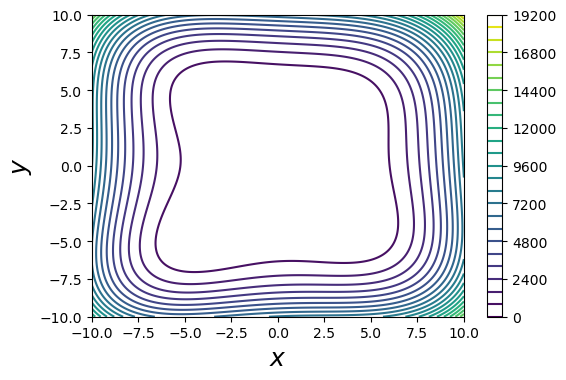

In [8]:
import matplotlib.pyplot as plt

def h(x, y):
    return ((x**2 + y - 10)**2 + (x + y**2 - 17)**2)

fig, ax = plt.subplots(dpi=100)
x_ = y_ = np.linspace(-10, 10, 1_000)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, h(X, Y), 25)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
plt.colorbar(c, ax=ax)
plt.show()